In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import seaborn as sns

from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.layers import Dense, Input, LSTM, Embedding, Dropout, Activation
from keras.layers import Bidirectional, GlobalMaxPool1D
from keras.models import Model
from keras import initializers, regularizers, constraints, optimizers, layers
from keras.utils.vis_utils import plot_model

from sklearn.multiclass import OneVsRestClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.tree import DecisionTreeClassifier

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory

import os
print(os.listdir("../input"))

# Any results you write to the current directory are saved as output.

Using TensorFlow backend.


['train.csv', 'sample_submission.csv', 'test.csv']


In [2]:
train = pd.read_csv('../input/train.csv')
test = pd.read_csv('../input/test.csv')

First thing, is explore the data

In [3]:
train.head()
print(len(train))

159571


In [4]:
train['Clean'] = train[['toxic','severe_toxic','obscene','threat','insult','identity_hate']].sum(axis = 1)
train.head()

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate,Clean
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0,0
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0,0
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0,0
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0,0
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0,0


Text(0.5, 1.0, 'Frequency of Toxic Comments')

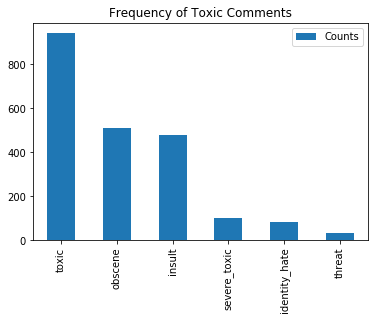

In [5]:
toxic_train = train[train['Clean']>0]
sums = toxic_train.iloc[:1000,2:8].sum()
sums = pd.DataFrame(sums, columns = ['Counts']).sort_values(by = 'Counts', ascending = False)
sums.plot(kind = 'bar')
plt.title('Frequency of Toxic Comments')

In [6]:
train.isnull().any()

#no empty values

id               False
comment_text     False
toxic            False
severe_toxic     False
obscene          False
threat           False
insult           False
identity_hate    False
Clean            False
dtype: bool

In [7]:
def length_text(x):
    word_segments = x.split()
    lengths = len(word_segments)
    return lengths

train['Length'] = train['comment_text'].apply(length_text)

/opt/conda/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


(0, 400)

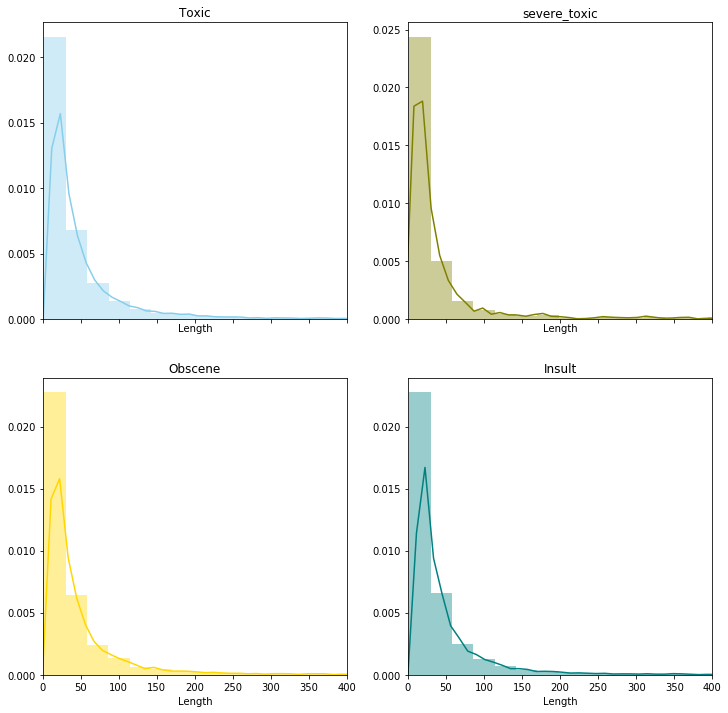

In [8]:
# plot
f, axes = plt.subplots(2, 2, figsize=(12, 12), sharex=True)
sns.distplot( train[train['toxic']==1]['Length'], color="skyblue", ax=axes[0, 0])
sns.distplot( train[train['severe_toxic']==1]['Length'] , color="olive", ax=axes[0, 1])
sns.distplot( train[train['obscene']==1]['Length'] , color="gold", ax=axes[1, 0])
sns.distplot( train[train['insult']==1]['Length'] , color="teal", ax=axes[1, 1])
axes[0, 0].set_title('Toxic')
axes[0, 1].set_title('severe_toxic')
axes[1, 0].set_title('Obscene')
axes[1, 1].set_title('Insult')
plt.xlim(0,400)

In [9]:
#define my x and y variables
list_classes = ["toxic", "severe_toxic", "obscene", "threat", "insult", "identity_hate"]
y = train[list_classes].values
list_sentences_train = train["comment_text"]
list_sentences_test = test["comment_text"]

This is how Kera's preprocessing with Tokenizer, fit on text, and texts to sequences is used

In [10]:
max_features = 1000
tokenizer = Tokenizer(num_words = max_features) #initialize the tokenizer, max_features is how many indexs do we allow,
                                                #e.g. max_features = 10 means the index will go from 1 to 10
tokenizer.fit_on_texts(list_sentences_train)    #splits the texts into words e.g. 'i','like','dogs'
list_tokenized_train = tokenizer.texts_to_sequences(list_sentences_train)  #convert each word into an index
list_tokenized_test = tokenizer.texts_to_sequences(list_sentences_test)
#list_tokenized_train #from this we see that each text is not equal in size because some comments will be long and some will be short

maxlen = 200 #the good way to see the best maxlen is to look at the histogram above, we see that 200 is a good cutoff, since 200> is very little
X_t = pad_sequences(list_tokenized_train, maxlen=maxlen) #this convert all unequal comment lists into equal size with length of maxlen
X_te = pad_sequences(list_tokenized_test, maxlen=maxlen) #this convert all unequal comment lists into equal size with length of maxlen
X_t.shape

(159571, 200)

This is how Kera's preprocessing with Tokenizer, fit on text, and texts to matrix is used

In [11]:
max_features_v2 = 10
tokenizer_v2 = Tokenizer(num_words = max_features_v2) #initialize the tokenizer, max_features is how many indexs do we allow,
                                                #e.g. max_features = 10 means the index will go from 1 to 9
tokenizer_v2.fit_on_texts(list_sentences_train)    #splits the texts into words e.g. 'i','like','dogs'
list_tokenized_train_v2 = tokenizer_v2.texts_to_matrix(list_sentences_train, mode='count')  #the column will be the index (unique word), and it just shows the count of each word in each text. 
list_tokenized_test_v2 = tokenizer_v2.texts_to_matrix(list_sentences_test, mode='count')
#list_tokenized_train_v2 
list_tokenized_train_v2.shape #there are max_features number of rows because we capped off the index to that, so 10 columns. 

(159571, 10)

using an embedding, lstm

In [12]:
Input = Input(shape=(maxlen,))
embed_size = 128

model = Embedding(max_features, embed_size)(Input)
model = LSTM(60, return_sequences=True,name='lstm_layer')(model)
model = GlobalMaxPool1D()(model)
model = Dropout(0.1)(model)
model = Dense(50, activation="relu")(model)
model = Dropout(0.1)(model)
model = Dense(6, activation="sigmoid")(model)

model = Model(inputs=Input, outputs=model)
model.compile(loss='binary_crossentropy',
                  optimizer='adam',
                  metrics=['accuracy'])

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


In [13]:
#commented out because it takes a long time to train, but it works 
#batch_size = 32
#epochs = 2
#model.fit(X_t,y, batch_size=batch_size, epochs=epochs, validation_split=0.1)

In [14]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 200)               0         
_________________________________________________________________
embedding_1 (Embedding)      (None, 200, 128)          128000    
_________________________________________________________________
lstm_layer (LSTM)            (None, 200, 60)           45360     
_________________________________________________________________
global_max_pooling1d_1 (Glob (None, 60)                0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 60)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 50)                3050      
_________________________________________________________________
dropout_2 (Dropout)          (None, 50)                0         
__________

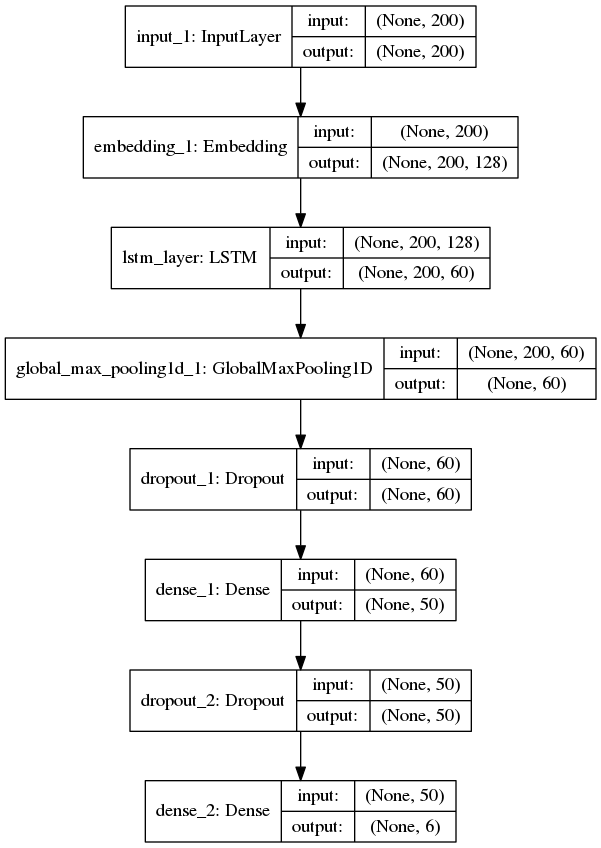

In [15]:
plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)
from IPython.display import Image
Image(retina=True, filename='model_plot.png')

Using the text to matrix and sklearn

In [16]:
model = OneVsRestClassifier(MultinomialNB())
model.fit(list_tokenized_train_v2,y)
score = model.score(list_tokenized_train_v2,y)
print(score)


0.858107049526543


In [17]:
model = DecisionTreeClassifier()
model.fit(list_tokenized_train_v2,y)
score = model.score(list_tokenized_train_v2,y)
print(score)


0.928965789523159
